## PI-GAT model and architecture

C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typin

Using device: cuda
Created 80 windows.
Starting continual learning with edge normalization...

--- Window 1/80 ---
Training with early stopping...
Epoch 20: Train=0.1751, Val=0.1624
Early stopping at epoch 25

--- Window 2/80 ---
Training with early stopping...
Early stopping at epoch 11

--- Window 3/80 ---
Training with early stopping...
Early stopping at epoch 11

--- Window 4/80 ---
Training with early stopping...
Epoch 20: Train=0.0835, Val=0.0515
Early stopping at epoch 21

--- Window 5/80 ---
Training with early stopping...
Epoch 20: Train=0.0585, Val=0.0483
Epoch 40: Train=0.0398, Val=0.0315
Epoch 60: Train=0.0260, Val=0.0172
Early stopping at epoch 77

--- Window 6/80 ---
Training with early stopping...
Early stopping at epoch 14

--- Window 7/80 ---
Training with early stopping...
Epoch 20: Train=0.0133, Val=0.0047
Early stopping at epoch 22

--- Window 8/80 ---
Training with early stopping...
Epoch 20: Train=0.0124, Val=0.0081
Early stopping at epoch 25

--- Window 9/80 ---


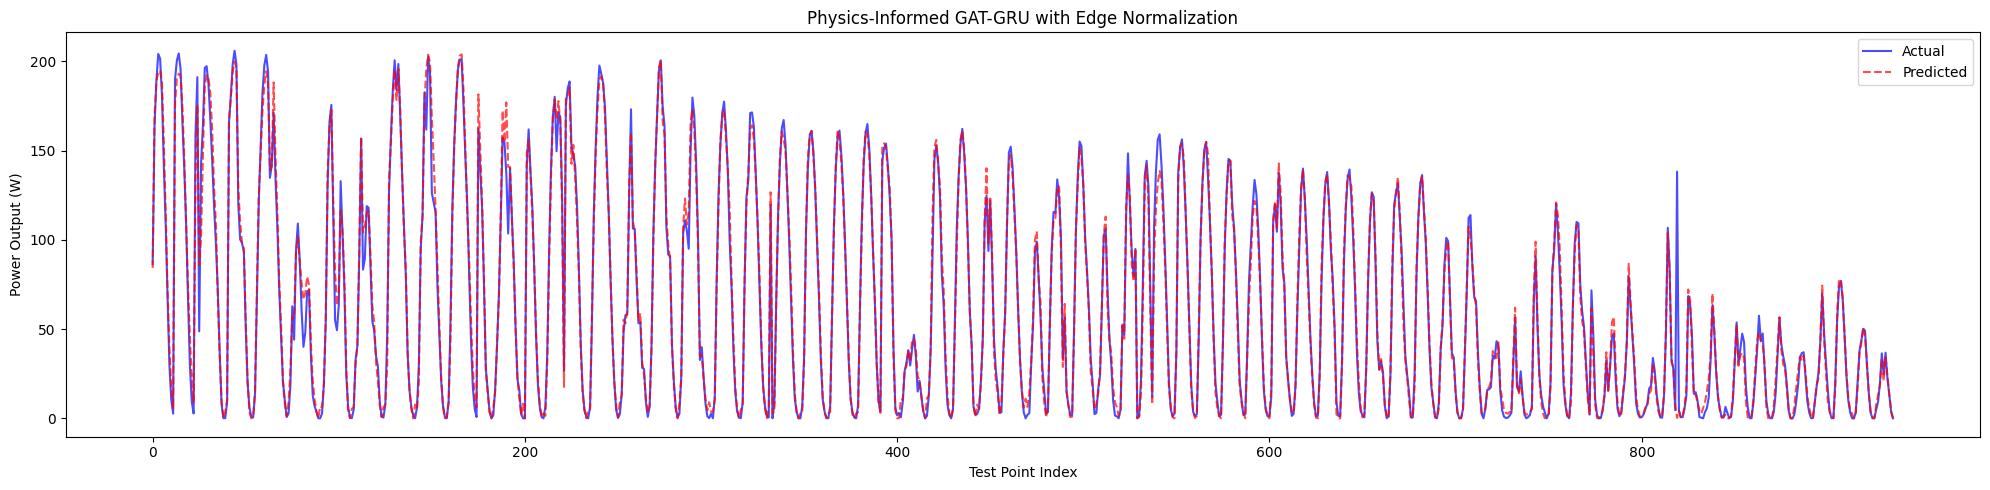

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
import os
import random

# =====================================================
# REPRODUCIBILITY FIX — set all random seeds
# =====================================================
def set_seed(seed=63):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(63)

# --------------------------
# Device
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Core configuration
# --------------------------
features = ['Glw', 'Gsw', 'T_PV', 'T_air', 'U', 'deltaT', 'q_HFM', 'cos_incidence_angle']
target = 'P_measured'

# --------------------------
# Load data
# --------------------------
data = pd.read_csv("filtered_dataset_positive.csv")
data['date'] = pd.to_datetime(data['date'])
data['cos_incidence_angle'] = np.cos(np.radians(data['incidence angle']))

# ==============================================================
# 1. Physics-informed edge weights
# ==============================================================

def compute_physics_edge_weights(row):
    """Computes the 4 physics-informed weights."""
    eps = 1e-6
    w1 = row['Gsw'] * row['cos_incidence_angle']               # Effective irradiance
    w2 = 1.0 / (row['deltaT'] + eps)                           # Temperature effect
    w3 = row['U'] * (row['deltaT'] + eps) * row['Gsw']         # Wind cooling
    w4 = row['q_HFM'] / (row['deltaT'] + eps)                  # Heat flux interaction
    return [w1, w2, w3, w4]


# ==============================================================
# 2. Graph creation with edge normalization
# ==============================================================

def compute_edge_norm_stats(dataframe):
    """Compute mean/std of edge attributes for normalization (training window only)."""
    attrs = []
    for _, row in dataframe.iterrows():
        attrs.append(compute_physics_edge_weights(row))
    attrs = np.array(attrs)
    mean = np.mean(attrs, axis=0)
    std = np.std(attrs, axis=0) + 1e-6
    return mean, std


def create_physics_graph(dataframe, features, target, scaler_X, edge_mean, edge_std):
    """Creates a graph and applies edge normalization."""
    num_timesteps = len(dataframe)
    edge_index, edge_attr, node_features = [], [], []

    gsw_idx = features.index('Gsw')
    gsw_mean = scaler_X.mean_[gsw_idx]
    gsw_scale = scaler_X.scale_[gsw_idx]
    scaled_50 = (50 - gsw_mean) / (gsw_scale + 1e-6)

    for i in range(num_timesteps):
        row = dataframe.iloc[i]
        module_idx, env_idx, delta_idx = i * 3, i * 3 + 1, i * 3 + 2

        attrs = np.array(compute_physics_edge_weights(row))
        # -------- Edge normalization --------
        attrs = (attrs - edge_mean) / edge_std
        attrs = attrs.tolist()

        # Edge list
        edges = [
            [module_idx, env_idx], [env_idx, module_idx],
            [module_idx, delta_idx], [delta_idx, module_idx],
            [env_idx, delta_idx], [delta_idx, env_idx]
        ]
        edge_index.extend(edges)
        edge_attr.extend([attrs] * len(edges))

        # Node features
        mod_feat = [row['T_PV'], 0.0, 0.0, 0.0]
        env_feat = [row['Gsw'], row['cos_incidence_angle'], row['T_air'],
                    np.exp(-max(0, row['Gsw']) / (scaled_50 + 1e-6))]
        del_feat = [row['deltaT'], row['q_HFM'], 0.0, 0.0]
        node_features.extend([mod_feat, env_feat, del_feat])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_features = torch.tensor(node_features, dtype=torch.float)
    target_values = torch.tensor(dataframe[target].values, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index,
                edge_attr=edge_attr, y=target_values,
                num_timesteps=num_timesteps)


# ==============================================================
# 3. Sliding-window date generation
# ==============================================================

def create_window_dates(data, train_days=28, val_days=2, test_days=1):
    all_dates = sorted(data['date'].unique())
    total_window = train_days + val_days + test_days
    train_date_list, val_date_list, test_date_list = [], [], []

    for i in range(len(all_dates) - total_window + 1):
        train_dates = all_dates[i:i + train_days]
        val_dates = all_dates[i + train_days:i + train_days + val_days]
        test_dates = all_dates[i + train_days + val_days:i + train_days + val_days + test_days]
        train_date_list.append(train_dates)
        val_date_list.append(val_dates)
        test_date_list.append(test_dates)
    print(f"Created {len(train_date_list)} windows.")
    return train_date_list, val_date_list, test_date_list


# ==============================================================
# 4. Model definition
# ==============================================================

class EnhancedPhysicsGATModel(nn.Module):
    def __init__(self, input_dim_mod, input_dim_env, input_dim_del, hidden_dim, gru_hidden_dim, dropout=0.3):
        super().__init__()
        self.proj_mod = nn.Linear(input_dim_mod, hidden_dim)
        self.proj_env = nn.Linear(input_dim_env, hidden_dim)
        self.proj_del = nn.Linear(input_dim_del, hidden_dim)

        self.conv1 = GATConv(hidden_dim, hidden_dim, edge_dim=4, heads=8, concat=True)
        self.conv2 = GATConv(hidden_dim * 8, hidden_dim * 2, edge_dim=4, heads=8, concat=True)
        gat_output_dim = hidden_dim * 2 * 8
        self.conv3 = GATConv(gat_output_dim, gat_output_dim, edge_dim=4, heads=4, concat=False)

        self.gru = nn.GRU(gat_output_dim, gru_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_timesteps = data.num_timesteps
        node_types = torch.arange(x.size(0), device=x.device) % 3
        x_proj = torch.zeros(x.size(0), self.conv1.in_channels, device=x.device)
        x_proj[node_types == 0] = self.proj_mod(x[node_types == 0])
        x_proj[node_types == 1] = self.proj_env(x[node_types == 1])
        x_proj[node_types == 2] = self.proj_del(x[node_types == 2])

        # GAT layers Using Tanh as requested
        x = F.tanh(self.conv1(x_proj, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv3(x, edge_index, edge_attr))

        gat_output_dim = x.size(1)
        x_reshaped = x.view(num_timesteps, 3, gat_output_dim)
        x_module_sequence = x_reshaped[:, 0, :].unsqueeze(0)

        x, _ = self.gru(x_module_sequence)
        x = self.fc(x.squeeze(0)).squeeze(-1)
        return x


# ==============================================================
# 5. Main training & evaluation loop
# ==============================================================

if __name__ == "__main__":
    train_date_lists, val_date_lists, test_date_lists = create_window_dates(data)

    input_dim_mod = 4
    input_dim_env = 4
    input_dim_del = 4
    hidden_dim = 64
    gru_hidden_dim = 64

    model = EnhancedPhysicsGATModel(input_dim_mod, input_dim_env, input_dim_del,
                                    hidden_dim, gru_hidden_dim, dropout=0.3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    criterion = nn.MSELoss()

    num_epochs = 200
    patience = 10
    best_model_path = "best_window_model_norm.pth"

    P_actual_list, P_pred_list, test_dates_list, test_hours_list = [], [], [], []
    print("Starting continual learning with edge normalization...")

    for i in range(len(train_date_lists)):
        print(f"\n--- Window {i+1}/{len(train_date_lists)} ---")

        train_raw = data[data['date'].isin(train_date_lists[i])]
        val_raw = data[data['date'].isin(val_date_lists[i])]
        test_raw = data[data['date'].isin(test_date_lists[i])]

        if train_raw.empty or val_raw.empty or test_raw.empty:
            print("Empty split, skipping.")
            continue

        # Fit scalers on training data
        scaler_X, scaler_y = StandardScaler(), StandardScaler()
        scaler_X.fit(train_raw[features])
        scaler_y.fit(train_raw[[target]])

        # Transform splits
        def scale_df(df):
            df_scaled = df.copy()
            df_scaled[features] = scaler_X.transform(df[features])
            df_scaled[target] = scaler_y.transform(df[[target]])
            return df_scaled

        train_scaled = scale_df(train_raw)
        val_scaled = scale_df(val_raw)
        test_scaled = scale_df(test_raw)

        # ---- Edge normalization stats computed on training only ----
        edge_mean, edge_std = compute_edge_norm_stats(train_scaled)

        # Create graphs
        train_g = create_physics_graph(train_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        val_g = create_physics_graph(val_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        test_g = create_physics_graph(test_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)

        best_val_loss, patience_counter = float('inf'), 0
        print("Training with early stopping...")
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(train_g)
            loss = criterion(out, train_g.y)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_g)
                val_loss = criterion(val_out, val_g.y)

            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}: Train={loss.item():.4f}, Val={val_loss.item():.4f}")

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # ---- Evaluation ----
        model.load_state_dict(torch.load(best_model_path))
        model.eval()
        with torch.no_grad():
            preds = model(test_g).cpu().numpy()
            actuals = test_g.y.cpu().numpy()

        preds_unscaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        preds_unscaled = np.maximum(preds_unscaled, 0)
        actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

        P_actual_list.extend(actuals_unscaled.tolist())
        P_pred_list.extend(preds_unscaled.tolist())
        test_dates_list.extend(test_raw['date'].values.tolist())
        test_hours_list.extend(test_raw['Hour'].values.tolist())

    if os.path.exists(best_model_path):
        os.remove(best_model_path)

    results_df = pd.DataFrame({
        'date': test_dates_list,
        'Hour': test_hours_list,
        'P_actual': P_actual_list,
        'P_predicted': P_pred_list
    })
    results_df.to_csv("predictions_continual_edgeNorm_tanH.csv", index=False)

    mae = np.mean(np.abs(results_df['P_actual'] - results_df['P_predicted']))
    print(f"\n=== FINAL RESULTS WITH EDGE NORMALIZATION ===")
    print(f"MAE: {mae:.2f} W")

    plt.figure(figsize=(20, 5))
    plt.plot(results_df.index, results_df['P_actual'], label='Actual', color='blue', alpha=0.7)
    plt.plot(results_df.index, results_df['P_predicted'], label='Predicted', color='red', linestyle='--', alpha=0.7)
    plt.title("Physics-Informed GAT-GRU with Edge Normalization")
    plt.xlabel("Test Point Index")
    plt.ylabel("Power Output (W)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("prediction_plot_edgeNorm_tanH.png")
    plt.show()


## PIGAT with uncertainty

In [12]:
# ============================================================
# PHYSICS-INFORMED GNN UNCERTAINTY ANALYSIS MODULE
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path

# ============================================================
# --- EDGE NORMALIZATION HELPER ---
# ============================================================

def compute_edge_norm_stats(train_df):
    """Compute mean and std of physics-informed edge attributes for normalization."""
    eps = 1e-6
    gsw = train_df['Gsw'].values
    deltaT = train_df['deltaT'].values
    qhfm = train_df['q_HFM'].values
    U = train_df['U'].values
    w1 = gsw * np.cos(np.radians(train_df.get('incidence angle', 0)))  # effective irradiance
    w2 = 1 / (deltaT + eps)
    w3 = U * (deltaT + eps) * gsw
    w4 = qhfm / (deltaT + eps)
    edge_stack = np.stack([w1, w2, w3, w4], axis=1)
    edge_mean = edge_stack.mean(axis=0)
    edge_std = edge_stack.std(axis=0) + eps
    return edge_mean, edge_std


# ============================================================
# --- UNCERTAINTY CORE ---
# ============================================================

def add_uncertainty(df, sigma_gsw=0.05, sigma_tair=1.0):
    """Apply Gaussian noise to Gsw (% noise) and T_air (°C noise)."""
    noisy = df.copy()
    if 'Gsw' in noisy.columns:
        noisy['Gsw'] = noisy['Gsw'] * (1 + np.random.normal(0, sigma_gsw, len(noisy)))
    if 'T_air' in noisy.columns:
        noisy['T_air'] = noisy['T_air'] + np.random.normal(0, sigma_tair, len(noisy))
    return noisy


def evaluate_under_uncertainty_MC_for_df(
    model, base_df_raw, features, target, scaler_X, scaler_y,
    edge_mean, edge_std, create_graph_fn, device,
    sigma_gsw_list, sigma_tair_list, n_mc=30, window_id=None, outdir="uncertainty_out"
):
    """
    Monte Carlo uncertainty propagation for one test window.
    Generates per-noise CSVs with mean±std predictions and a summary CSV with metrics.
    """
    Path(outdir).mkdir(parents=True, exist_ok=True)
    y_true = base_df_raw[target].values.astype(float)
    summary_rows = []

    for sigma_g in sigma_gsw_list:
        for sigma_t in sigma_tair_list:
            preds_mc = []

            for mc in range(n_mc):
                noisy_df = add_uncertainty(base_df_raw, sigma_g, sigma_t)
                scaled = noisy_df.copy()
                scaled[features] = scaler_X.transform(noisy_df[features])
                scaled[target] = scaler_y.transform(noisy_df[[target]])

                #g = create_graph_fn(scaled, features, target, scaler_X).to(device)
                g = create_graph_fn(scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
                model.eval()
                with torch.no_grad():
                    pred = model(g).cpu().numpy().flatten()

                pred_unscaled = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
                pred_unscaled = np.maximum(pred_unscaled, 0.0)
                preds_mc.append(pred_unscaled)

            preds_mc = np.stack(preds_mc, axis=0)
            pred_mean = preds_mc.mean(axis=0)
            pred_std = preds_mc.std(axis=0)

            mae = np.mean(np.abs(pred_mean - y_true))
            rmse = np.sqrt(np.mean((pred_mean - y_true) ** 2))
            abs_err = np.abs(pred_mean - y_true)
            sigma = pred_std + 1e-12
            cov_1 = np.mean(abs_err <= 1.0 * sigma)
            cov_2 = np.mean(abs_err <= 2.0 * sigma)

            summary_rows.append({
                "window_id": window_id,
                "sigma_Gsw(%)": sigma_g * 100,
                "sigma_Tair(°C)": sigma_t,
                "MAE(W)": mae,
                "RMSE(W)": rmse,
                "MeanPredStd(W)": pred_std.mean(),
                "Coverage_±1σ": cov_1,
                "Coverage_±2σ": cov_2,
                "n_samples": len(y_true)
            })

            # Save per-sample predictions
            tag = f"W{window_id}_G{int(sigma_g*100)}_T{int(sigma_t)}"
            per_sample = pd.DataFrame({
                "date": base_df_raw["date"].values,
                "Hour": base_df_raw["Hour"].values,
                "P_measured": y_true,
                "Pred_Mean": pred_mean,
                "Pred_Std": pred_std,
                "Gsw": base_df_raw["Gsw"].values,
                "T_air": base_df_raw["T_air"].values
            })
            per_sample.to_csv(os.path.join(outdir, f"uncertainty_predVar_{tag}.csv"), index=False)

            print(f"[Uncert] window={window_id}  G={sigma_g*100:.1f}%  T={sigma_t:.1f}°C  "
                  f"MAE={mae:.2f}W  RMSE={rmse:.2f}W  meanσ={pred_std.mean():.2f}W  "
                  f"cov±1σ={cov_1:.2f}  cov±2σ={cov_2:.2f}")

    summary_df = pd.DataFrame(summary_rows)
    summary_path = os.path.join(outdir, f"uncertainty_summary_W{window_id}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Saved summary: {summary_path}")
    return summary_df


# ============================================================
# --- VISUALIZATION UTILITIES ---
# ============================================================

def plot_mae_heatmap(summary_df, title="MAE under Input Uncertainty", savepath=None):
    pivot = summary_df.pivot(index="sigma_Tair(°C)", columns="sigma_Gsw(%)", values="MAE(W)")
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.xlabel("Irradiance noise (%)")
    plt.ylabel("Temperature noise (°C)")
    plt.imshow(pivot.values, origin='lower', cmap='coolwarm', aspect='auto')
    plt.colorbar(label="MAE (W)")
    plt.xticks(np.arange(len(pivot.columns)), labels=pivot.columns)
    plt.yticks(np.arange(len(pivot.index)), labels=pivot.index)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=300)
    plt.show()


def plot_coverage(summary_df, savepath=None):
    cov1 = summary_df["Coverage_±1σ"].mean()
    cov2 = summary_df["Coverage_±2σ"].mean()
    plt.figure(figsize=(4, 4))
    plt.bar(["±1σ", "±2σ"], [cov1, cov2], color=["#4B9CD3", "#77DD77"])
    plt.ylim(0, 1)
    plt.ylabel("Fraction covered")
    plt.title("Empirical Coverage")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=300)
    plt.show()


def plot_uncertainty_band(csv_path, date_start=None, date_end=None, max_points=None, savepath=None):
    df = pd.read_csv(csv_path, parse_dates=["date"])
    df = df.sort_values(["date", "Hour"]).reset_index(drop=True)
    if date_start and date_end:
        df = df[(df["date"] >= pd.to_datetime(date_start)) & (df["date"] <= pd.to_datetime(date_end))]
    if max_points:
        df = df.iloc[:max_points]

    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df["P_measured"], color="blue", label="Measured")
    plt.plot(df.index, df["Pred_Mean"], color="red", label="Predicted mean")
    plt.fill_between(df.index, df["Pred_Mean"]-df["Pred_Std"], df["Pred_Mean"]+df["Pred_Std"],
                     color="red", alpha=0.2, label="±1σ")
    plt.xlabel("Sample Index")
    plt.ylabel("Power (W)")
    plt.title("Predicted Power ±1σ Band")
    plt.legend()
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=300)
    plt.show()


# ============================================================
# --- DRIVER FUNCTION ---
# ============================================================

def run_uncertainty_for_window(
    model, window_id, test_raw, features, target, scaler_X, scaler_y,
    edge_mean, edge_std, create_graph_fn, device,
    sigma_gsw_list=(0.00, 0.05, 0.10), sigma_tair_list=(0.0, 1.0, 2.0),
    n_mc=30, outdir="uncertainty_out"
):
    summary = evaluate_under_uncertainty_MC_for_df(
        model=model,
        base_df_raw=test_raw,
        features=features,
        target=target,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        edge_mean=edge_mean,
        edge_std=edge_std,
        create_graph_fn=create_graph_fn,
        device=device,
        sigma_gsw_list=sigma_gsw_list,
        sigma_tair_list=sigma_tair_list,
        n_mc=n_mc,
        window_id=window_id,
        outdir=outdir
    )

    # Plot heatmap + coverage
    plot_mae_heatmap(summary, f"MAE vs Noise (Window {window_id})",
                     os.path.join(outdir, f"heatmap_W{window_id}.png"))
    plot_coverage(summary, os.path.join(outdir, f"coverage_W{window_id}.png"))

    # Plot one representative band (10% Gsw, 2°C)
    tag = f"W{window_id}_G10_T2"
    file_path = os.path.join(outdir, f"uncertainty_predVar_{tag}.csv")
    if os.path.exists(file_path):
        plot_uncertainty_band(file_path, savepath=os.path.join(outdir, f"band_W{window_id}.png"))
    else:
        print("Representative uncertainty band CSV not found.")

    return summary





=== Running uncertainty analysis on Window 74 ===
[Uncert] window=74  G=0.0%  T=0.0°C  MAE=3.43W  RMSE=4.31W  meanσ=0.00W  cov±1σ=0.00  cov±2σ=0.00
[Uncert] window=74  G=0.0%  T=1.0°C  MAE=3.45W  RMSE=4.34W  meanσ=0.26W  cov±1σ=0.00  cov±2σ=0.09
[Uncert] window=74  G=0.0%  T=2.0°C  MAE=3.42W  RMSE=4.30W  meanσ=0.71W  cov±1σ=0.18  cov±2σ=0.27
[Uncert] window=74  G=5.0%  T=0.0°C  MAE=3.50W  RMSE=4.40W  meanσ=0.81W  cov±1σ=0.00  cov±2σ=0.27
[Uncert] window=74  G=5.0%  T=1.0°C  MAE=3.52W  RMSE=4.47W  meanσ=0.88W  cov±1σ=0.00  cov±2σ=0.18
[Uncert] window=74  G=5.0%  T=2.0°C  MAE=3.35W  RMSE=4.20W  meanσ=1.15W  cov±1σ=0.18  cov±2σ=0.36
[Uncert] window=74  G=10.0%  T=0.0°C  MAE=3.59W  RMSE=4.52W  meanσ=1.57W  cov±1σ=0.18  cov±2σ=0.45
[Uncert] window=74  G=10.0%  T=1.0°C  MAE=3.31W  RMSE=4.17W  meanσ=1.56W  cov±1σ=0.18  cov±2σ=0.45
[Uncert] window=74  G=10.0%  T=2.0°C  MAE=3.22W  RMSE=4.05W  meanσ=1.75W  cov±1σ=0.36  cov±2σ=0.55
Saved summary: uncertainty_out\uncertainty_summary_W74.csv


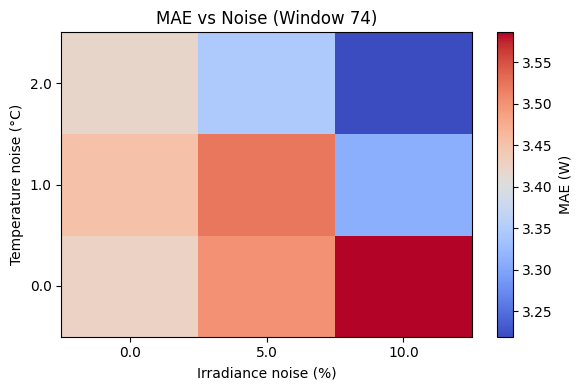

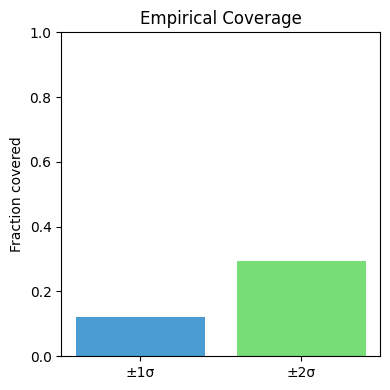

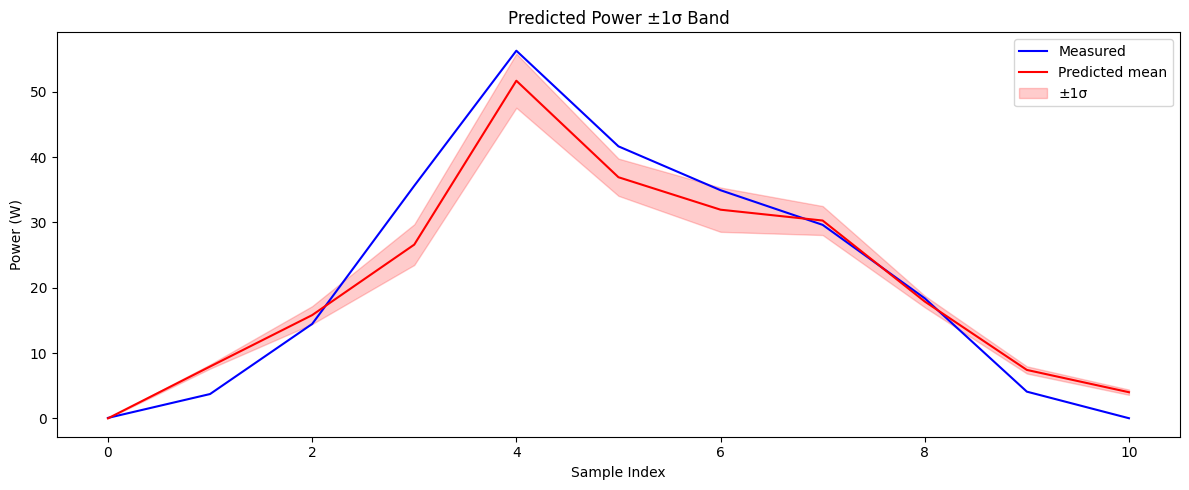

   window_id  sigma_Gsw(%)  sigma_Tair(°C)    MAE(W)   RMSE(W)  \
0         74           0.0             0.0  3.426168  4.313387   
1         74           0.0             1.0  3.452798  4.341081   
2         74           0.0             2.0  3.420871  4.297633   
3         74           5.0             0.0  3.500933  4.395132   
4         74           5.0             1.0  3.522188  4.468316   
5         74           5.0             2.0  3.346660  4.200825   
6         74          10.0             0.0  3.586076  4.520481   
7         74          10.0             1.0  3.310696  4.170598   
8         74          10.0             2.0  3.219553  4.053690   

   MeanPredStd(W)  Coverage_±1σ  Coverage_±2σ  n_samples  
0        0.000011      0.000000      0.000000         11  
1        0.264103      0.000000      0.090909         11  
2        0.713807      0.181818      0.272727         11  
3        0.813476      0.000000      0.272727         11  
4        0.878415      0.000000      0.18181

In [15]:

# ============================================================
# CORRECT EXAMPLE CALL
# ============================================================

# 1. Choose the specific window index you want to analyze
target_window_idx = 74 # Change this to 10, 20, 75, etc.

print(f"\n=== Running uncertainty analysis on Window {target_window_idx} ===")

# 2. FETCH THE CORRECT DATA for this specific window
# You need to use the lists you created earlier to get the right dates
target_test_dates = test_date_lists[target_window_idx]
target_test_raw = data[data['date'].isin(target_test_dates)].reset_index(drop=True)

# 3. FIT SCALERS FOR THIS WINDOW (Crucial step!)
# You must scale this window's data using its corresponding training data, 
# just like you did during training.
target_train_dates = train_date_lists[target_window_idx]
target_train_raw = data[data['date'].isin(target_train_dates)]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaler_X.fit(target_train_raw[features])
scaler_y.fit(target_train_raw[[target]])

# 4. COMPUTE EDGE STATS FOR THIS WINDOW
edge_mean, edge_std = compute_edge_norm_stats(target_train_raw)

# 5. RUN ANALYSIS
summary_i = run_uncertainty_for_window(
    model=model,
    window_id=target_window_idx,
    test_raw=target_test_raw,      # Passing the CORRECT data now
    features=features,
    target=target,
    scaler_X=scaler_X,             # Passing the CORRECT scalers
    scaler_y=scaler_y,
    edge_mean=edge_mean,           # Passing the CORRECT edge stats
    edge_std=edge_std,
    create_graph_fn=create_physics_graph,
    device=device,
    sigma_gsw_list=(0.00, 0.05, 0.10),
    sigma_tair_list=(0.0, 1.0, 2.0),
    n_mc=30,
    outdir="uncertainty_out"
)

print(summary_i)

## Benchmark against PVWatts

In [4]:
import pandas as pd

# ------------------------------------------------------------
# 1. Load BOTH datasets
# ------------------------------------------------------------
df_pred = pd.read_csv("predictions_continual_edgeNorm_tanH.csv")
df_raw = pd.read_csv("filtered_dataset_positive.csv")

# ------------------------------------------------------------
# 2. FIX DATE IN df_pred (scientific notation → datetime)
# ------------------------------------------------------------
df_pred['date'] = pd.to_datetime(df_pred['date'].astype('int64'), unit='ns')

# ------------------------------------------------------------
# 3. FIX DATE IN df_raw (proper ISO format)
# ------------------------------------------------------------
df_raw['date'] = pd.to_datetime(df_raw['date'], format="%Y-%m-%d")

# ------------------------------------------------------------
# 4. Convert Hour to integer
# ------------------------------------------------------------
df_pred['Hour'] = df_pred['Hour'].astype(int)
df_raw['Hour'] = df_raw['Hour'].astype(int)

# ------------------------------------------------------------
# 5. Create merge key
# ------------------------------------------------------------
df_pred['merge_key'] = df_pred['date'].astype(str) + "_" + df_pred['Hour'].astype(str)
df_raw['merge_key'] = df_raw['date'].astype(str) + "_" + df_raw['Hour'].astype(str)

# ------------------------------------------------------------
# 6. Merge datasets
# ------------------------------------------------------------
df_merged = pd.merge(
    df_pred,
    df_raw,
    on='merge_key',
    how='left',
    suffixes=('_gnn', '_raw')
)

# Optional clean-up
df_merged = df_merged.rename(columns={'date_gnn': 'date'})

# ------------------------------------------------------------
# 7. Save merged dataset
# ------------------------------------------------------------
df_merged.to_csv("GNN_vs_PVWATTS_benchmark.csv", index=False)

print("Merged dataset saved as GNN_vs_PVWATTS_benchmark.csv")
print(df_merged.head())


Merged dataset saved as GNN_vs_PVWATTS_benchmark.csv
        date  Hour_gnn    P_actual  P_predicted      merge_key   date_raw  \
0 2023-05-02         7   86.437675    84.269135   2023-05-02_7 2023-05-02   
1 2023-05-02         8  163.614700   169.399582   2023-05-02_8 2023-05-02   
2 2023-05-02         9  189.187088   188.556320   2023-05-02_9 2023-05-02   
3 2023-05-02        10  204.214828   194.486252  2023-05-02_10 2023-05-02   
4 2023-05-02        11  201.550491   194.801025  2023-05-02_11 2023-05-02   

   Hour_raw         Glw         Gsw  P_calculated_opt  P_measured  \
0         7  326.415366  439.757463        123.123119   86.437677   
1         8  301.079952  722.581939        202.308202  163.614694   
2         9  300.486701  811.606268        227.233198  189.187090   
3        10  302.377876  860.070453        240.802181  204.214831   
4        11  306.088636  846.618426        237.035888  201.550490   

   P_pvwatts_dc       T_PV      T_air         U     deltaT         et


Plots saved.


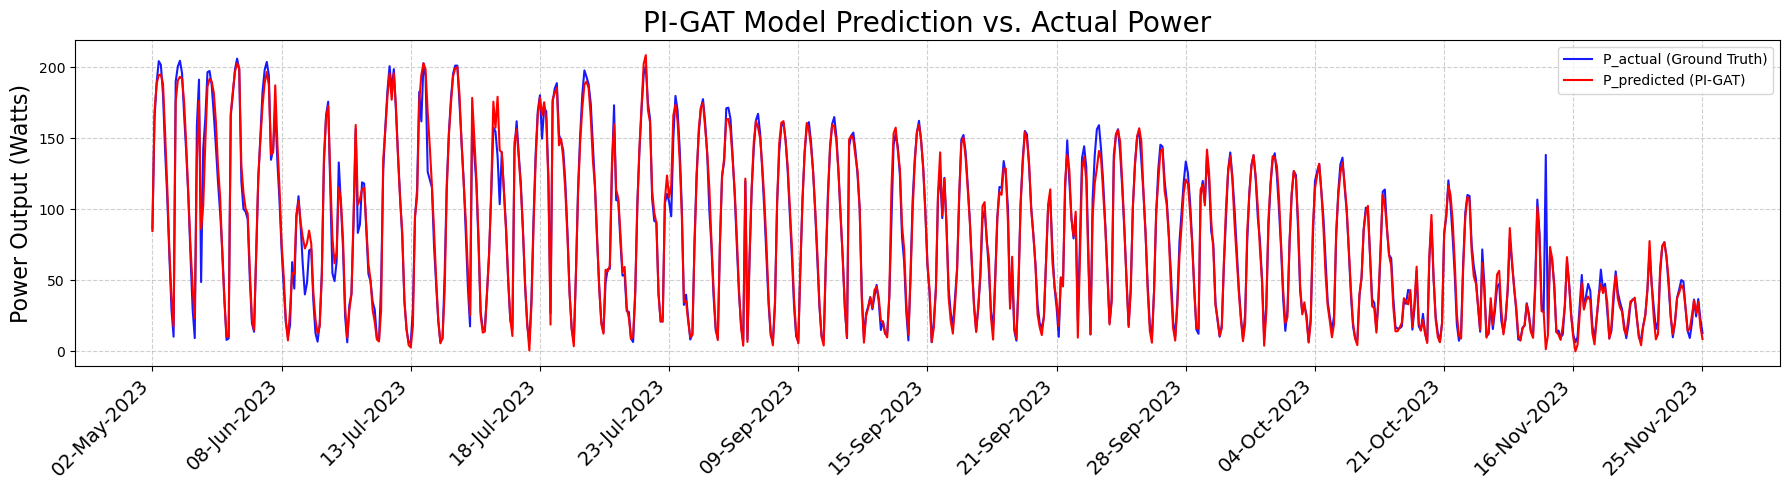

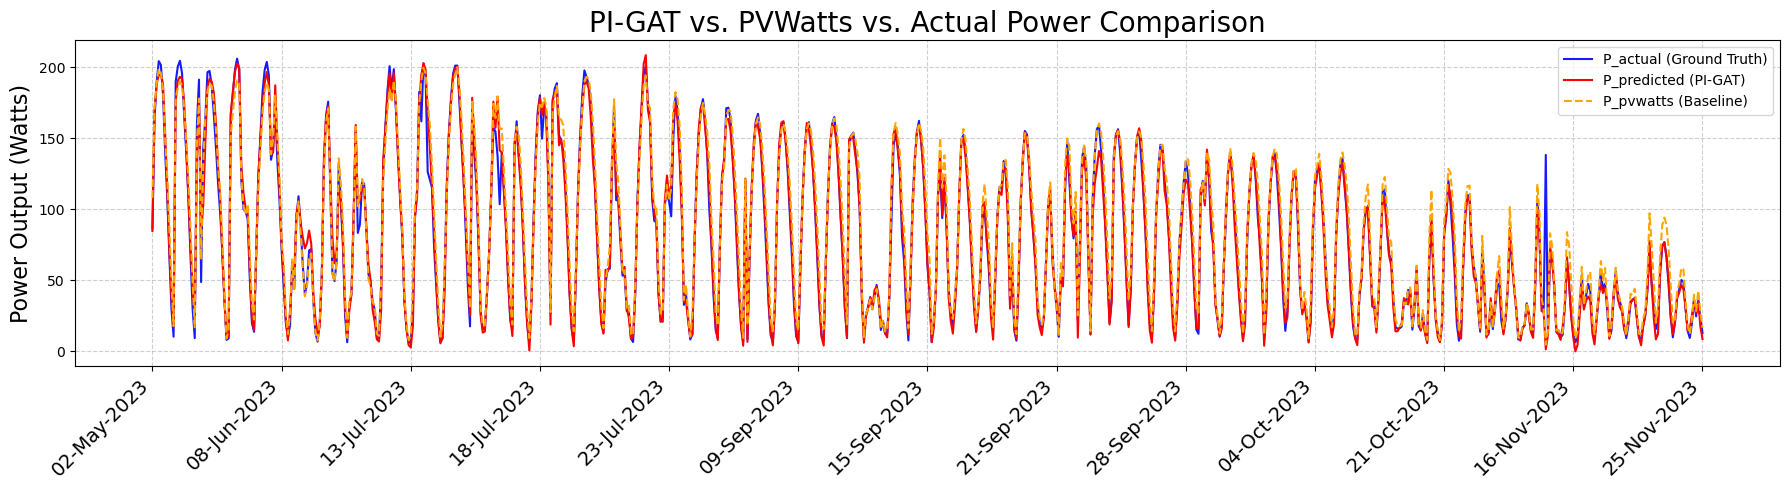

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Define a safe MAPE function ---
def calculate_mape(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE),
    safely handling cases where y_true is zero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filter out entries where the actual value is zero to avoid division by zero
    mask = y_true != 0
    if not np.any(mask):
        return np.nan # Or 0, or inf, depending on desired behavior
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- 1. Load Data ---
FILE_NAME = "GNN_vs_PVWATTS_benchmark.csv"
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: File not found. Please make sure '{FILE_NAME}' is in the same directory.")
    exit()

# --- 2. Prepare Data ---
df = df.rename(columns={
    'P_predicted': 'P_predicted_GNN',
    'P_pvwatts_dc': 'P_predicted_PVWatts'
})

# Create datetime column for sorting and labeling
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['Hour_gnn'].astype(str) + ':00:00')
df = df.sort_values('datetime')

# Filter for daytime/meaningful power. 
# This removes nighttime zeros which distort metrics like MAPE.
df_daytime = df[df['P_actual'] > 6].copy()

# --- Reset the index ---
df_daytime = df_daytime.reset_index(drop=True)

# Store columns for metrics
y_true = df_daytime['P_actual']
y_pred_gnn = df_daytime['P_predicted_GNN']
y_pred_pvwatts = df_daytime['P_predicted_PVWatts']


# --- 3. Calculate Metrics (for both models) ---

def get_all_metrics(y_true, y_pred, model_name):
    """Calculates all requested metrics for a given model."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred) # Use our safe MAPE function
    
    return pd.Series({
        'Model': model_name,
        'MAE (W)': mae,
        'MSE (W^2)': mse,
        'RMSE (W)': rmse,
        'R-squared': r2,
        'MAPE (%)': mape
    })

# Get metrics for your GNN model
metrics_gnn = get_all_metrics(y_true, y_pred_gnn, 'GNN (Our Method)')

# Get metrics for the PVWatts baseline
metrics_pvwatts = get_all_metrics(y_true, y_pred_pvwatts, 'PVWatts (Baseline)')

# Combine into a single table
metrics_df = pd.concat([metrics_gnn, metrics_pvwatts], axis=1).T


# --- 5. Generate Plots using SEQUENTIAL INDEX ---

def format_sequential_plot(ax, dataframe_for_labels):
    """Helper function to format the sequential plot x-axis."""
    ax.set_ylabel("Power Output (Watts)",size=16)
    
    # --- Create custom date ticks ---
    # We will place ~10 ticks evenly spaced across the data points
    num_points = len(dataframe_for_labels)
    tick_spacing = max(1, num_points // 12) # Calculate spacing for ~10 ticks
            
    tick_positions = np.arange(0, num_points, tick_spacing)
    
    # Get the date label ('Mon YYYY') from the original datetime column
    tick_labels = [
        dataframe_for_labels.iloc[i]['datetime'].strftime('%d-%b-%Y')  # <-- CHANGED
        for i in tick_positions
    ]
    
    # Set the custom ticks and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right',size=14)
    
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()

# --- Plot 1: GNN vs. Actual (Sequential) ---
fig1, ax1 = plt.subplots(figsize=(18, 5))
ax1.plot(df_daytime.index, df_daytime['P_actual'], label='P_actual (Ground Truth)', color='blue', alpha=0.9)
ax1.plot(df_daytime.index, df_daytime['P_predicted_GNN'], label='P_predicted (PI-GAT)', color='red', linestyle='-')
ax1.set_title("PI-GAT Model Prediction vs. Actual Power",size=20)
format_sequential_plot(ax1, df_daytime)
fig1.savefig("PI-GAT_vs_actual.png")

# --- Plot 2: All Models Comparison (Sequential) ---
fig2, ax2 = plt.subplots(figsize=(18, 5))
ax2.plot(df_daytime.index, df_daytime['P_actual'], label='P_actual (Ground Truth)', color='blue', alpha=0.9, linewidth=1.5)
ax2.plot(df_daytime.index, df_daytime['P_predicted_GNN'], label='P_predicted (PI-GAT)', color='red', linewidth=1.5)
ax2.plot(df_daytime.index, df_daytime['P_predicted_PVWatts'], label='P_pvwatts (Baseline)', color='orange', linestyle='--', linewidth=1.5)
ax2.set_title("PI-GAT vs. PVWatts vs. Actual Power Comparison",size=20)
format_sequential_plot(ax2, df_daytime)
fig2.savefig("all_models_comparison.png")

print("\nPlots saved.")


In [3]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("GNN_vs_PVWATTS_benchmark.csv")

# Ensure the columns are present
required_columns = ['date', 'Hour_gnn', 'P_actual', 'P_predicted', 'P_pvwatts_dc']
if not all(col in data.columns for col in required_columns):
    raise ValueError("Dataset is missing required columns")

# Extract the relevant columns
P_actual = data['P_actual'].values
P_predicted = data['P_predicted'].values
P_pvwatts_dc = data['P_pvwatts_dc'].values

# Calculate MAE
mae_predicted = np.mean(np.abs(P_actual - P_predicted))
mae_pvwatts = np.mean(np.abs(P_actual - P_pvwatts_dc))

# Calculate MAPE
# MAPE = (1/n) * Σ(|actual - predicted| / |actual|) * 100
# Add a small epsilon to avoid division by zero
epsilon = 1e-10
mape_predicted = np.mean(np.abs((P_actual - P_predicted) / (P_actual + epsilon))) * 100
mape_pvwatts = np.mean(np.abs((P_actual - P_pvwatts_dc) / (P_actual + epsilon))) * 100

# Print results
print("Comparison of P_actual vs P_predicted (Physics-Informed GAT):")
print(f"MAE: {mae_predicted:.2f} Watts")
#print(f"MAPE: {mape_predicted:.2f}%")
print("\nComparison of P_actual vs P_pvwatts_dc (PVWatts):")
print(f"MAE: {mae_pvwatts:.2f} Watts")
#print(f"MAPE: {mape_pvwatts:.2f}%")

Comparison of P_actual vs P_predicted (Physics-Informed GAT):
MAE: 4.25 Watts

Comparison of P_actual vs P_pvwatts_dc (PVWatts):
MAE: 6.90 Watts


## Anomaly Detection

In [9]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv("GNN_vs_PVWATTS_benchmark.csv")

# 2. Compute Residuals
df["residual"] = df["P_actual"] - df["P_predicted"]
df['cos_incidence_angle'] = np.cos(np.radians(df['incidence angle']))
# ============================================================
# METHOD A: Physics-Informed Z-Score (Contextual)
# ============================================================

# Rolling window on the sequence index (handling gaps/short days automatically)
rolling_mean = df["residual"].rolling(window=15, min_periods=5, center=True).mean()
rolling_std = df["residual"].rolling(window=15, min_periods=5, center=True).std()

rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')
rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

z_score = abs(df["residual"] - rolling_mean) / (rolling_std + 1e-6)

# Thresholds:
# 1. Statistical: Must be > 3 sigma away from neighbors
# 2. Practical: Must be > 10 Watts error (filters out tiny 1W noise at night)
# This catches "Zombie Sensors" (High Actual, Zero Predicted)
min_error_watts = 10.0
df["vote_physics"] = ((z_score > 3.0) & (abs(df["P_actual"]) > min_error_watts) & (abs(df["residual"]) > min_error_watts)).astype(int)

# ============================================================
# METHOD B & C: ML-Based Detection
# ============================================================

# CRITICAL: We removed 'Gsw', 'T_air', 'U' to prevent flagging "weird weather"
# We keep only features that describe the *system state* and *performance*
#ml_features = ["P_actual", "P_predicted", "residual", "deltaT", "q_HFM"]
ml_features = ["Gsw","T_PV", "T_air", "U", "deltaT", "eta", "P_actual", "residual", "q_HFM", 'cos_incidence_angle']

# Fill any tiny gaps (though filtered dataset should be clean)
X = df[ml_features].fillna(method='bfill').fillna(method='ffill')

# --- Method B: Isolation Forest ---
iso = IsolationForest(contamination=0.04, random_state=42, n_estimators=100)
df["vote_iso"] = ((iso.fit_predict(X) == -1)& (abs(df["P_actual"]) > min_error_watts)& (abs(df["residual"]) > min_error_watts)).astype(int)

# --- Method C: Local Outlier Factor (LOF) ---
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.04)
df["vote_lof"] = ((lof.fit_predict(X) == -1)& (abs(df["P_actual"]) > min_error_watts)& (abs(df["residual"]) > min_error_watts)).astype(int)

# ============================================================
# STEP 3: Majority Voting (Ensemble)
# ============================================================

df["anomaly_score"] = df["vote_physics"] + df["vote_iso"] + df["vote_lof"]

# Anomaly if at least 2 methods agree
df["anomaly_hybrid"] = df["anomaly_score"] >= 2

# ============================================================
# Summary & Save
# ============================================================
total_anomalies = df["anomaly_hybrid"].sum()
percent = (total_anomalies / len(df)) * 100

print(f"Anomalies Detected: {total_anomalies} ({percent:.2f}%)")
print("-" * 30)
print("Breakdown by Method:")
print(f"Physics Flags: {df['vote_physics'].sum()}")
print(f"IsoForest Flags: {df['vote_iso'].sum()}")
print(f"LOF Flags: {df['vote_lof'].sum()}")

df.to_csv("GNN_PV_anomalies_hybrid.csv", index=False)
print("Saved to GNN_PV_anomalies_hybrid_final.csv")

Anomalies Detected: 8 (0.85%)
------------------------------
Breakdown by Method:
Physics Flags: 3
IsoForest Flags: 13
LOF Flags: 13
Saved to GNN_PV_anomalies_hybrid_final.csv


C:\Temp\ipykernel_22276\430191007.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')
C:\Temp\ipykernel_22276\430191007.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')
C:\Temp\ipykernel_22276\430191007.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[ml_features].fillna(method='bfill').fillna(method='ffill')


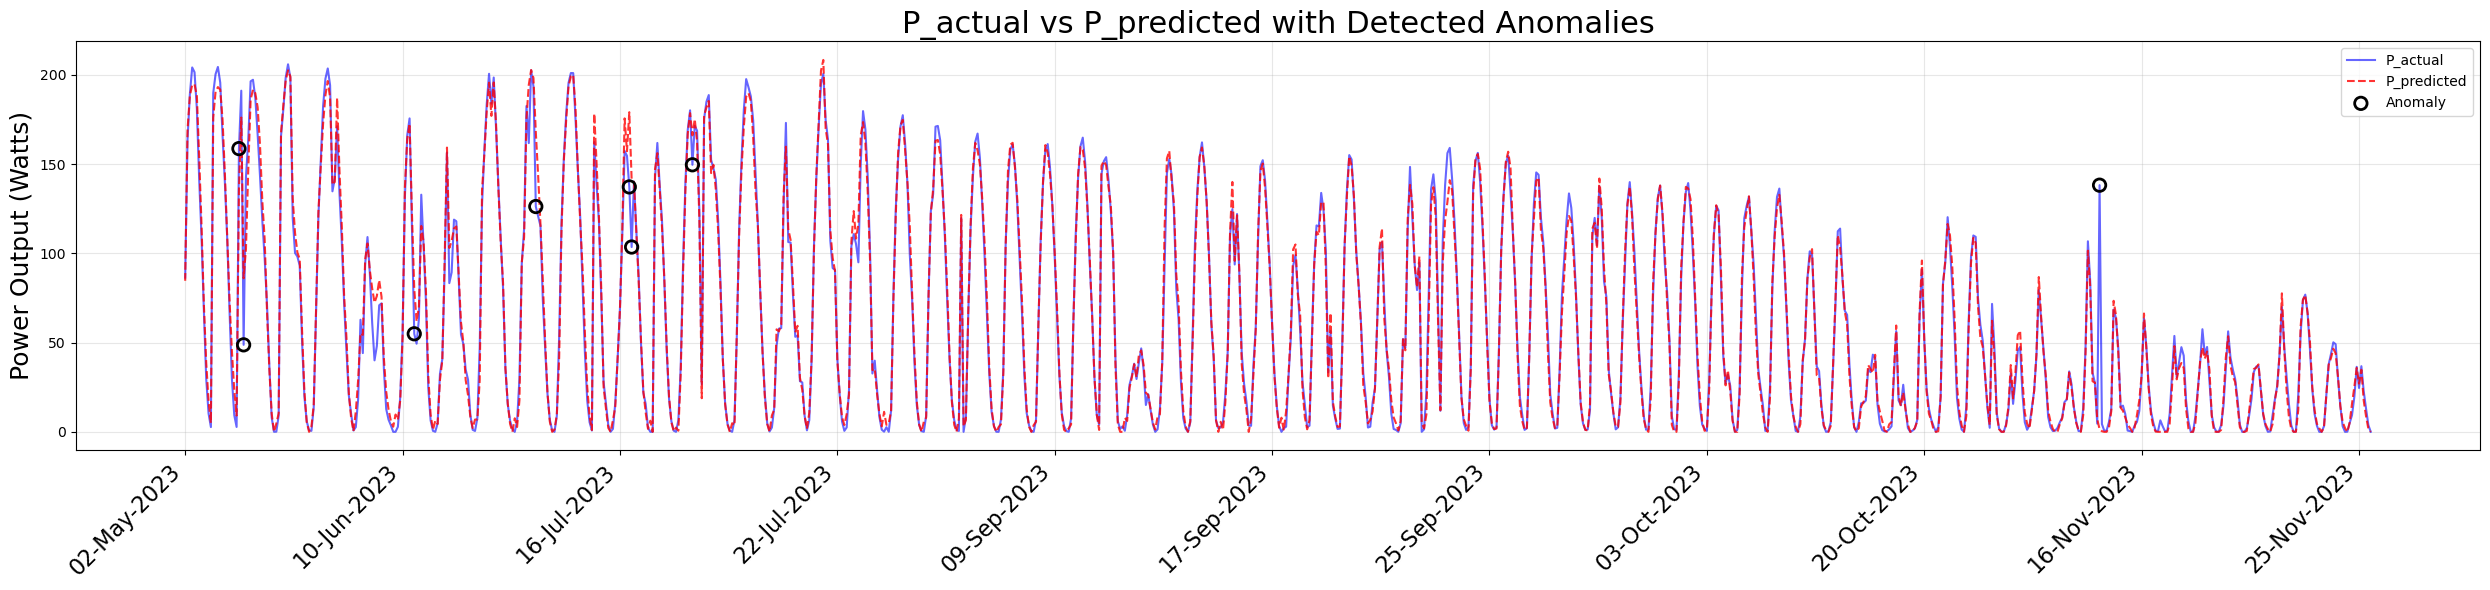

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("GNN_PV_anomalies_hybrid.csv")

# --- 1. Prepare Data ---

# A. Create the 'datetime' column (used for sorting and labeling)
df['datetime'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['Hour_gnn'].astype(str) + ':00:00'
)

# B. Sort by date and then reset the index
# This is the key: we get a new, clean sequential index (0, 1, 2...)
df = df.sort_values(by='datetime').reset_index(drop=True)

# --- 2. Plotting using the SEQUENTIAL INDEX ---

plt.figure(figsize=(25, 6))

# Plot lines using df.index as the x-value
plt.plot(df.index, df['P_actual'], label='P_actual', color='blue', alpha=0.6)
plt.plot(df.index, df['P_predicted'], label='P_predicted', color='red', linestyle='--', alpha=0.8)

# --- PLOT ANOMALIES (Multi-Color) ---

# 1. Original GNN/Residual Anomalies (Black Circles)
if 'anomaly_hybrid' in df.columns:
    # Filter
    anom_gnn = df[df['anomaly_hybrid'].astype(bool) == True]
    # Plot
    plt.scatter(anom_gnn.index, anom_gnn['P_actual'], 
                color='black', label='Anomaly', 
                marker='o', s=80, facecolors='none', linewidths=2, zorder=5) 
    # Note: facecolors='none' makes an empty circle so you can see points inside it

# 2. Isolation Forest Anomalies (Cyan X's)
if 'iso_anomaly' in df.columns:
    anom_iso = df[df['iso_anomaly'].astype(bool) == True]
    plt.scatter(anom_iso.index, anom_iso['P_actual'], 
                color='cyan', label='Isolation Forest', 
                marker='x', s=80, linewidths=2, zorder=6)

# 3. Local Outlier Factor Anomalies (Magenta Triangles)
if 'lof_anomaly' in df.columns:
    anom_lof = df[df['lof_anomaly'].astype(bool) == True]
    plt.scatter(anom_lof.index, anom_lof['P_actual'], 
                color='magenta', label='Local Outlier Factor', 
                marker='^', s=60, zorder=7)

# --- 3. Format X-Axis with Date Labels ---
ax = plt.gca()

num_points = len(df)
tick_spacing = max(1, num_points // 10) 
            
tick_positions = np.arange(0, num_points, tick_spacing)

tick_labels = [
    df.iloc[i]['datetime'].strftime('%d-%b-%Y') 
    for i in tick_positions
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=16)

# --- 4. Final Touches ---
plt.title("P_actual vs P_predicted with Detected Anomalies", fontsize=22)
plt.ylabel("Power Output (Watts)", fontsize=18)
plt.legend(loc='upper right') # Moved legend to not block data
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
